# Basic {mod}`biolord` pipeline

This code presents the pipeline of {mod}`biolord` for learning decoupled representations of known and unknown attributes in single-cell data.

Here we train a {class}`~biolord.Biolord` model on the spatio-temporally resolved single cell atlas of the Plasmodium liver stage {cite}`afriat:22` to recover gene expression trends associated with infected state.

In [1]:
import pandas as pd
import numpy as np

import scanpy as sc
import biolord

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_rel

[rank: 0] Global seed set to 0


In [2]:
warnings.simplefilter("ignore", UserWarning)

## Setup the {class}`~anndata.AnnData`

In [3]:
adata = sc.read("adata_infected.h5ad", backup_url="https://figshare.com/ndownloader/files/39375713")
adata

AnnData object with n_obs × n_vars = 19053 × 8203
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident', 'eta_normalized', 'nCounts_tot', 'normalized_PBA', 'coarse_time_orig', 'zone', 'status', 'status_control', 'time_int', 'split_random'
    var: 'org', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'coarse_time_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'status_colors', 'status_control_colors', 'umap', 'zone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'scaledata'
    obsp: 'connectivities', 'distances'

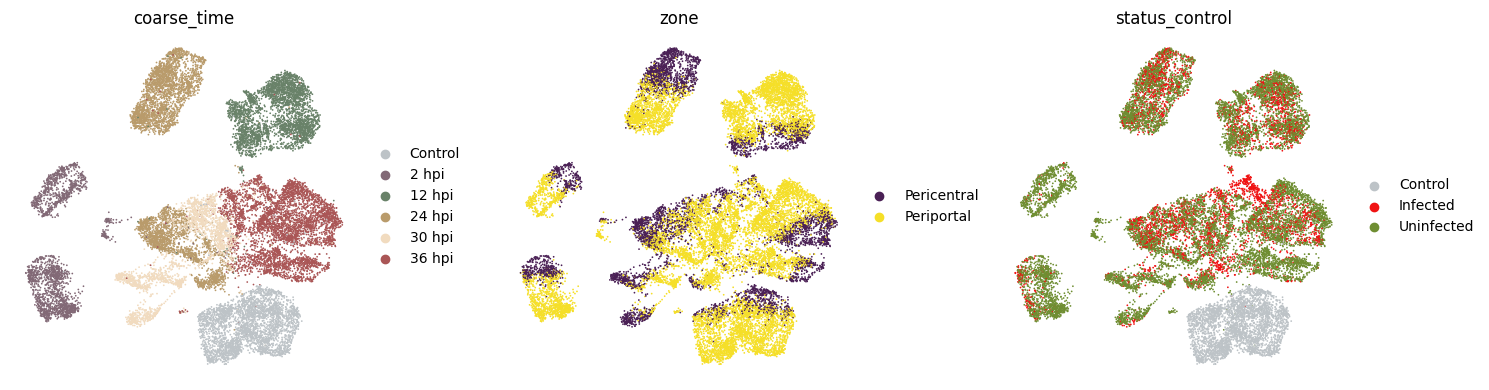

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, c in enumerate(["coarse_time", "zone", "status_control"]):
    sc.pl.umap(adata, color=[c], ax=axs[i], show=False)
    axs[i].set_axis_off()
plt.tight_layout()
plt.show()

By calling {meth}`biolord.Biolord.setup_anndata()` we set the supervised attributes used for disentanglement.
The function takes as input:

* `adata`: the adata object for the setting.
* `ordered_attributes_keys`: the keys in {attr}`~anndata.AnnData.obs` or {attr}`~anndata.AnnData.obsm` defining ordered attributes.
* `categorical_attributes_keys`: the keys in {attr}`~anndata.AnnData.obs` defining categorical attributes.

In [5]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=None,
    categorical_attributes_keys=["time_int", "status_control", "zone"],
)

## Run {class}`~biolord.Biolord`

### Instantiate a {class}`~biolord.Biolord` model 

We instantiate the model given the `module_params`.

These are parameters required to construct the model's module, the various networks included in a {class}`~biolord.Biolord` model.

The parameters include standard architecture design values (e.g. width, depth, and latent dimension) and loss functon choices alongwith {class}`~biolord.Biolord` oriented parameters. The {class}`~biolord.Biolord` model parameters are:
* `reconstruction_penalty`: internal penalty term weighting the componenets of the reconstruction loss
* `unknown_attribute_penalty`: the penalty weight of the unknown_attribute magnitued in the final loss objective.
* `unknown_attribute_noise_param`:  the std added to unknown attribute embedding

In [6]:
module_params = {
    "autoencoder_width": 1024,
    "autoencoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": 4,
    "loss_ae": "gauss",
    "loss_ordered_attribute": "gauss",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}

In [7]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spatio_temporal_infected",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_random",
)

[rank: 0] Global seed set to 42


### Train the model

To train the model we provide `trainer_params`. These are paramters which dictate the training regime, e.g., learning rate, weight decay and scheduler type.

In [8]:
trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [9]:
model.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 70/500:  14%|█▍        | 70/500 [02:44<16:51,  2.35s/it, v_num=1, val_generative_mean_accuracy=0.964, val_generative_var_accuracy=0.776, val_biolord_metric=0.87, val_reconstruction_loss=18.8, val_unknown_attribute_penalty_loss=22, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=18, unknown_attribute_penalty_loss=30.2]     
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.874. Signaling Trainer to stop.


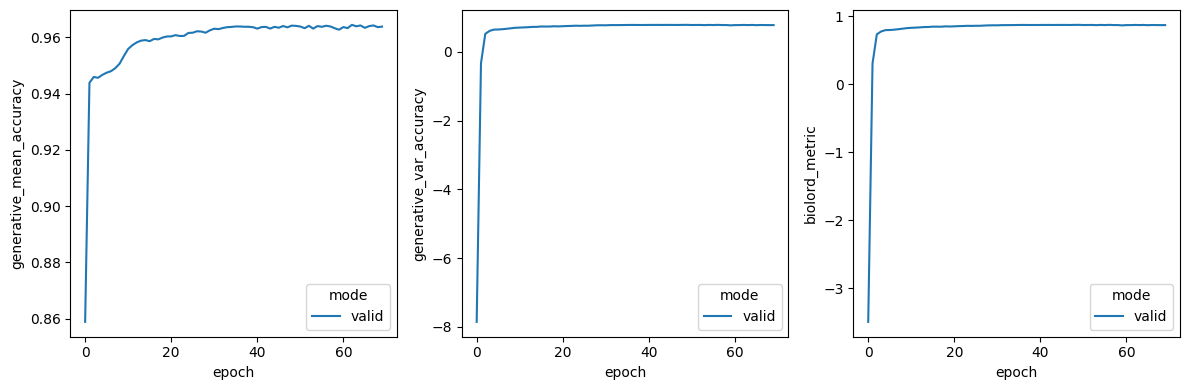

In [10]:
size = 4
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Recover infected signal

### Compute expression predictions

Create a {class}`~anndata.AnnData` object with control cells

In [11]:
idx_source = np.where((adata.obs["split_random"] == "train") & (adata.obs["coarse_time"] == "Control"))[0]

adata_source = adata[idx_source].copy()

Use {meth}`~biolord.Biolord.compute_prediction_adata()` to obtain the expression predictions of control cells. The function takes as input:
* `adata`: the reference adata object to take attribute prediction categories.
* `adata_source`: the source adata to take initial state of the cells (i.e., the control cells).
* `target_attributes`: the attributes predictions are made with respect to (i.e., for `target_attributes = ["status_control"]` control cells will be evaluated at "Infected/Uninfected" status.
* `add_attributes`: attributes from the original adata to be added to the `adata_preds` object.

In [12]:
adata_preds = model.compute_prediction_adata(
    adata, adata_source, target_attributes=["status_control"], add_attributes=["zone", "eta_normalized"]
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  4.80it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  4.11it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:01,  2.51it/s]


### Visualize expression predictions

In [13]:
sc.pp.pca(adata_preds)
sc.pp.neighbors(adata_preds)
sc.tl.umap(adata_preds)

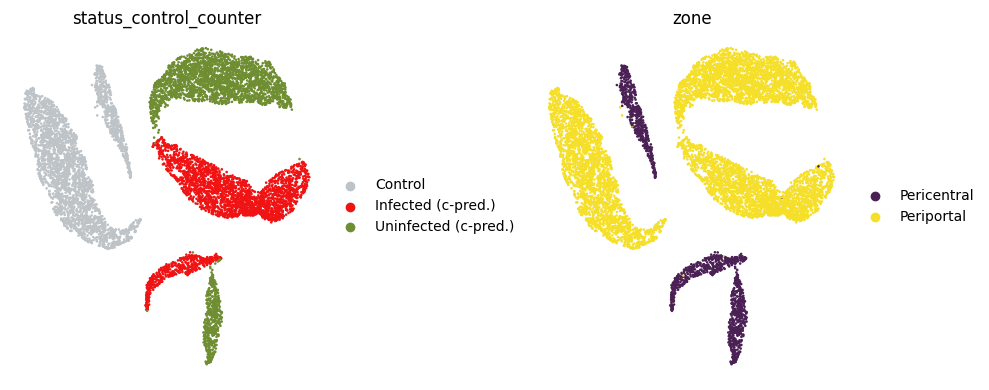

In [14]:
adata_preds.obs["status_control_counter"] = adata_preds.obs["status_control"].copy()
adata_preds.obs["status_control_counter"] = adata_preds.obs["status_control_counter"].cat.rename_categories(
    {"Infected": "Infected (c-pred.)", "Uninfected": "Uninfected (c-pred.)"}
)

adata_preds.uns["status_control_counter_colors"] = ["#bdc3c7", "#f01313", "#6f8e32"]

size = 4
fig, axs = plt.subplots(1, 2, figsize=(2 * (size + 1), size))

for i, c in enumerate(["status_control_counter", "zone"]):
    sc.pl.umap(adata_preds, color=[c], ax=axs[i], show=False)

    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

### Score genes

To find infection-related changes at the level of individual cells we use the dependent t-test for paired samples.
Testing for the null hypothesis that the counterfactual predictions and original expressions have identical average (expected) values.

In [15]:
scores_genes_ttest = {}
for gene in adata_source.var_names:
    res = ttest_rel(
        a=adata_preds[adata_preds.obs["status_control"] == "Infected", gene].X,
        b=adata_preds[adata_preds.obs["status_control"] == "Control", gene].X,
    )

    scores_genes_ttest[gene] = {"statistic": res.statistic[0], "pvalue": res.pvalue[0]}

In [16]:
df_pvalue = pd.DataFrame.from_dict(scores_genes_ttest).T
df_pvalue.head()

,statistic,pvalue
A1bg,45.032546,0.000000e+00
A1cf,16.502016,1.639028e-58
A2ml1,79.963170,0.000000e+00
Aaas,41.639395,9.846481e-297
Aacs,-53.408096,0.000000e+00
